In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
import pandas as pd
import wrds
import matplotlib.pyplot as plt


In [2]:
pd.set_option("display.max_columns", 500)

In [3]:
# sale = pd.read_csv("small.csv");
# df = sale[['item_type','country_code','slug_type','amount_paid_usd', 'currency','fmt_amt']].copy();
# df.dropna(axis=0, inplace=True)
# df2 = df.copy();
# temp_dict={'item_type':'item','country_code':'country','slug_type':'slug','currency':'curr'}
# varlist = list(df2.columns.values)

# for var, label in temp_dict.items():
#     varlist.remove(var)
#     df2 = pd.merge(df2[varlist], pd.get_dummies(df[var], prefix=label), left_index=True, right_index=True).copy();

#     varlist = list(df2.columns.values)

# df2.head(1)
# y=np.asarray(df2['fmt_amt'], dtype=int)
# df2.drop(columns='fmt_amt', inplace=True);
# df2, X_test, y, y_test = train_test_split(df2, y, test_size=0.8, random_state=4000, stratify=y);
# df2['fmt_amt'] = y;
# df2.to_csv("small2.csv", index=False);

In [12]:
df2 = pd.read_csv("small2.csv")

In [13]:
y=np.asarray(df2['fmt_amt'], dtype=int)
df2.drop(columns='fmt_amt', inplace=True);

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.2, random_state=4000, stratify=y);

In [36]:
skf = StratifiedKFold(n_splits=5, random_state=40, shuffle=True)
X_train.reset_index(drop=True, inplace=True)

In [37]:
X_train.iloc[:,[149,150]].head()

slug_t  curr_AUD
0       0         0
1       0         0
2       0         0
3       0         0
4       1         0

## Decision Tree

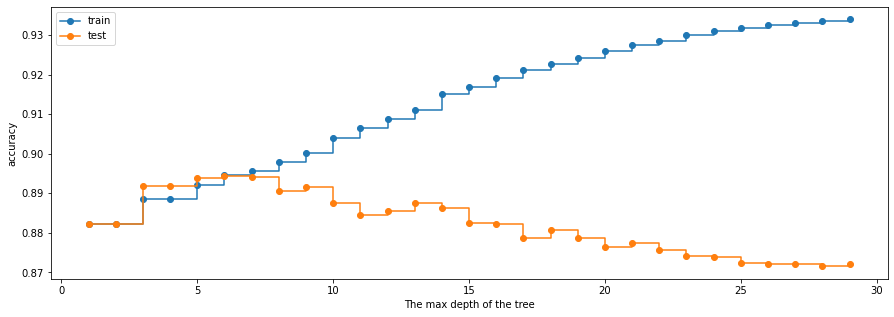

In [38]:
clfs = []
num_nodes = np.arange(1,30)
for i in num_nodes:

    clf = tree.DecisionTreeClassifier(random_state=2, max_depth=i)
    clf.fit(X_train, y_train)
    clfs.append(clf)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.set_xlabel("The max depth of the tree")
ax.set_ylabel("accuracy")
ax.set_title("")
ax.plot(num_nodes , train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(num_nodes, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()

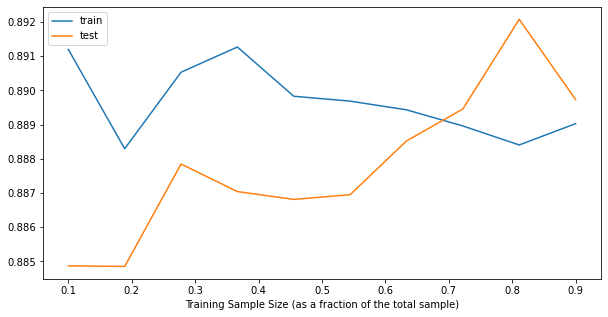

In [39]:
test_acc=[];
train_acc=[];
for k in np.linspace(0.1, 0.9, num=10, endpoint=True):
    X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=k, random_state=4000, stratify=y);
    clf = tree.DecisionTreeClassifier(random_state=2, criterion='gini', max_depth=3)
    clf.fit(X_train,y_train);
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test));
    
fig, ax = plt.subplots(1,1, figsize=(10,5));
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), train_acc, label='train')
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), test_acc, label='test')
ax.set_xlabel('Training Sample Size (as a fraction of the total sample)')
ax.legend()

In [40]:
clf = tree.DecisionTreeClassifier(random_state=2, criterion='gini')
clf.fit(X_train,y_train)
# fig, ax= plt.subplots(1,1, figsize=(10,20));
clf.score(X_test, y_test)

0.8547979088200574

In [41]:
validate=[];

for train_index, test_index in skf.split(X_train, y_train):

    X_, X_val = X_train.iloc[train_index,:], X_train.iloc[test_index,:];
    y_, y_val = y_train[train_index], y_train[test_index];
    
    clf = tree.DecisionTreeClassifier( random_state=2)
    path = clf.cost_complexity_pruning_path(X_, y_)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    clfs=[];
    for ccp_alpha in ccp_alphas:
        if ccp_alpha<=0:
            ccp_alpha=0;
        clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf.fit(X_, y_)
        clfs.append(clf);
    score= np.array([clf.score(X_val, y_val) for clf in clfs])
    validate.append([ccp_alphas[np.argmax(score)], np.amax(score)]);
pd.DataFrame(validate, columns=['Alpha','Validation Accuracy'])
    

Alpha  Validation Accuracy
0  0.000932             0.898990
1  0.002203             0.883544
2  0.001360             0.893671
3  0.000892             0.883544
4  0.001258             0.898734

In [42]:
alpha_ = np.mean(np.array(validate), axis=0)
alpha_

array([0.00132899, 0.89169671])

6


[Text(0.6071428571428571, 0.9285714285714286, 'X[0] <= 2.09\ngini = 0.208\nsamples = 1976\nvalue = [1743, 233]'),
 Text(0.5357142857142857, 0.7857142857142857, 'gini = 0.007\nsamples = 572\nvalue = [570, 2]'),
 Text(0.6785714285714286, 0.7857142857142857, 'X[2] <= 0.5\ngini = 0.275\nsamples = 1404\nvalue = [1173, 231]'),
 Text(0.6071428571428571, 0.6428571428571429, 'X[0] <= 12.88\ngini = 0.323\nsamples = 942\nvalue = [751, 191]'),
 Text(0.35714285714285715, 0.5, 'X[0] <= 5.105\ngini = 0.28\nsamples = 872\nvalue = [725, 147]'),
 Text(0.21428571428571427, 0.35714285714285715, 'X[0] <= 4.97\ngini = 0.347\nsamples = 354\nvalue = [275, 79]'),
 Text(0.14285714285714285, 0.21428571428571427, 'X[149] <= 0.5\ngini = 0.273\nsamples = 258\nvalue = [216, 42]'),
 Text(0.07142857142857142, 0.07142857142857142, 'gini = 0.351\nsamples = 163\nvalue = [126, 37]'),
 Text(0.21428571428571427, 0.07142857142857142, 'gini = 0.1\nsamples = 95\nvalue = [90, 5]'),
 Text(0.2857142857142857, 0.21428571428571427,

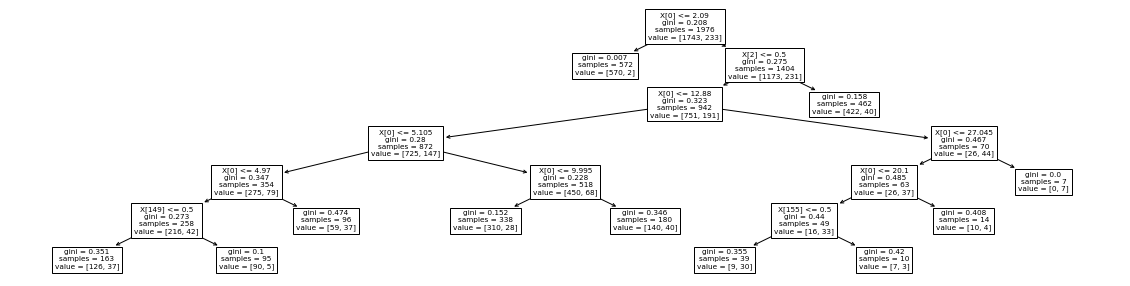

In [43]:
clf = tree.DecisionTreeClassifier(random_state=2, ccp_alpha=alpha_[0]);
clf = clf.fit(X_train, y_train);
print(clf.tree_.max_depth)
fig, ax = plt.subplots(1, 1, figsize=(20,5))
tree.plot_tree(clf)

In [44]:
clf.score(X_train,y_train),clf.score(X_test,y_test)

(0.896255060728745, 0.888076901455956)

## Boosted Decision Trees

In [45]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import zero_one_loss, accuracy_score

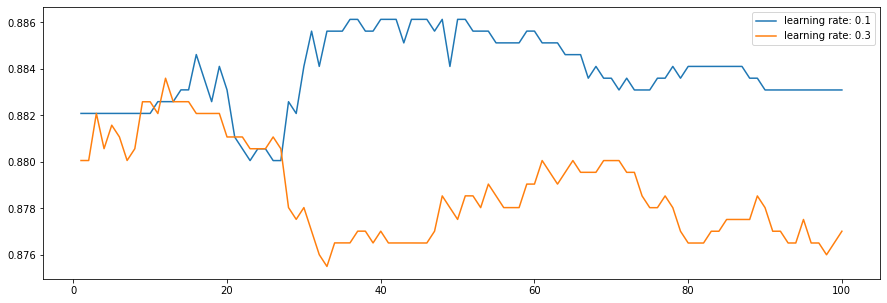

In [46]:
validate={};
for rate in [0.1, 0.3]:

    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=rate,
        max_depth=3, random_state=10)
    

    temp=np.zeros((5,100))
    i=0;
    for train_index, test_index in skf.split(X_train, y_train):
        
        X_, X_val = X_train.iloc[train_index,:], X_train.iloc[test_index,:];
        y_, y_val = y_train[train_index], y_train[test_index];

        clf.fit(X_, y_)
        for j, y_pred in enumerate(clf.staged_predict(X_val)):
            temp[i,j] =accuracy_score(y_val, y_pred)
        i+=1;
        
    validate['{}'.format(rate)] = np.mean(temp, axis=0)
    
    
fig, ax = plt.subplots(1,1, figsize=(15,5));
    
for key, value in validate.items():
    plt.plot(np.arange(1,101), value, label="learning rate: {}".format(key))
ax.legend()

In [49]:
num=40
clf = GradientBoostingClassifier(n_estimators=num, learning_rate=0.1,
        max_depth=3, random_state=10).fit(X_train, y_train)
clf2 = GradientBoostingClassifier(n_estimators=num, learning_rate=0.3,
        max_depth=3, random_state=10).fit(X_train, y_train)

print(clf.score(X_test, y_test))
print(clf2.score(X_test, y_test))

0.8893136207768846
0.8814435887346113


## KNN Methods

In [20]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [21]:
crossVal=[]
for k in range(1,8):
    temp=[];
    for train_index, test_index in skf.split(X_train, y_train):
        
        X_, X_val = X_train.iloc[train_index,:], X_train.iloc[test_index,:];
        y_, y_val = y_train[train_index], y_train[test_index];
        neigh = KNN(n_neighbors=k);
        neigh.fit(X_, y_);

        temp.append(neigh.score(X_val, y_val))
    crossVal.append(temp);
cross_val = pd.DataFrame(crossVal, index=range(1,8));
cross_val['average']=cross_val[cross_val.columns.values].apply(lambda x:np.mean(x), axis=1);
cross_val['std']=cross_val[cross_val.columns.values].apply(lambda x:np.std(x), axis=1);
cross_val

0         1         2         3         4   average       std
1  0.840909  0.805063  0.822785  0.840506  0.830380  0.827929  0.012124
2  0.873737  0.875949  0.863291  0.878481  0.865823  0.871456  0.005372
3  0.853535  0.865823  0.848101  0.868354  0.860759  0.859315  0.006896
4  0.876263  0.883544  0.878481  0.883544  0.881013  0.880569  0.002608
5  0.871212  0.868354  0.873418  0.868354  0.868354  0.869939  0.001882
6  0.881313  0.881013  0.881013  0.883544  0.883544  0.882085  0.001092
7  0.876263  0.870886  0.870886  0.860759  0.881013  0.871961  0.006167

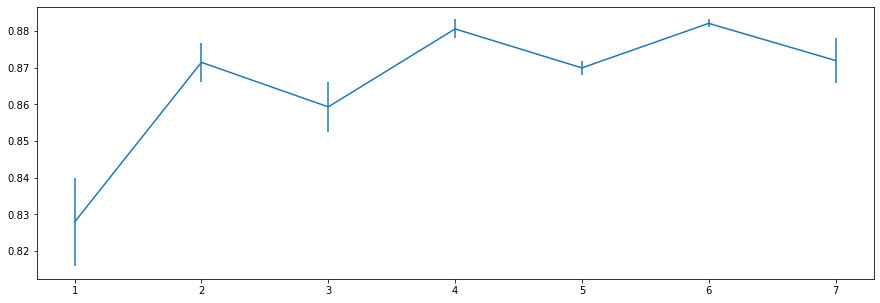

In [22]:
fig, ax = plt.subplots(1,1, figsize=(15, 5));
ax.errorbar(
    x=np.arange(1,8, dtype='int'),
    y=cross_val["average"],
    yerr=cross_val["std"],
)
ax.set_xticks(np.arange(1,8, dtype='int'))

In [23]:
neigh = KNN(n_neighbors=4);
neigh.fit(X_train,y_train);
neigh.score(X_test,y_test)

0.8830738096576536

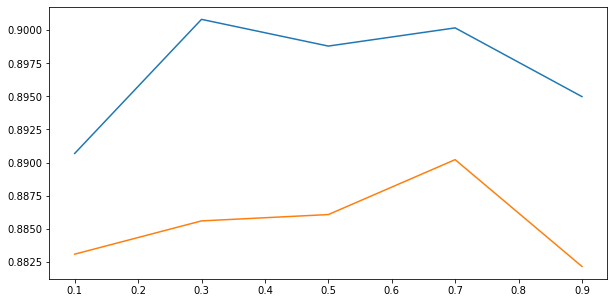

In [24]:
test_acc=[];
train_acc=[];
for k in np.linspace(0.1, 0.9, num=10, endpoint=True):
    X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=k, random_state=4000, stratify=y);
    neigh = KNN(n_neighbors=4);
    neigh.fit(X_train, y_train);
    
    train_acc.append(neigh.score(X_train, y_train))
    test_acc.append(neigh.score(X_test, y_test));
    
fig, ax = plt.subplots(1,1, figsize=(10,5));
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), train_acc)
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), test_acc)

## SVM

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

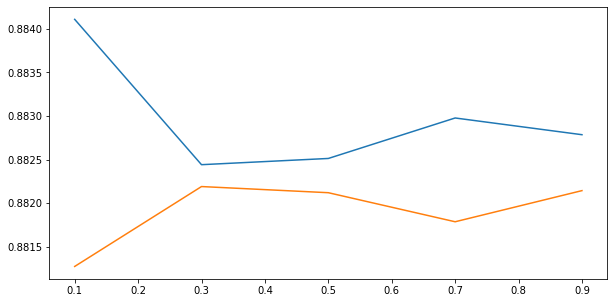

In [28]:
test_acc=[];
train_acc=[];
for k in np.linspace(0.1, 0.9, num=5, endpoint=True):
    X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=k, random_state=4000, stratify=y);
    clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto'))
    clf.fit(X_train, y_train)
    clf.score(X_test, y_test)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test));
    
fig, ax = plt.subplots(1,1, figsize=(10,5));
plt.plot(1-np.linspace(0.1, 0.9, num=5, endpoint=True), train_acc)
plt.plot(1-np.linspace(0.1, 0.9, num=5, endpoint=True), test_acc)

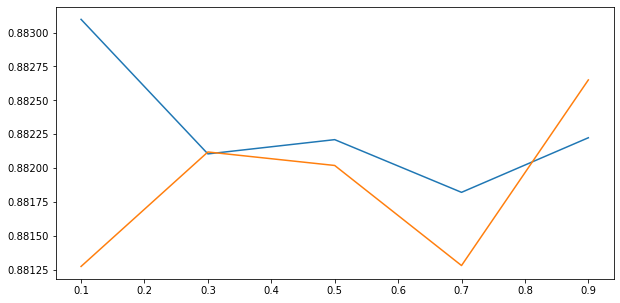

In [29]:
test_acc=[];
train_acc=[];
for k in np.linspace(0.1, 0.9, num=5, endpoint=True):
    X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=k, random_state=4000, stratify=y);
    clf = make_pipeline(StandardScaler(), SVC(kernel='sigmoid', gamma='auto'))
    clf.fit(X_train, y_train)
    clf.score(X_test, y_test)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test));
    
fig, ax = plt.subplots(1,1, figsize=(10,5));
plt.plot(1-np.linspace(0.1, 0.9, num=5, endpoint=True), train_acc)
plt.plot(1-np.linspace(0.1, 0.9, num=5, endpoint=True), test_acc)

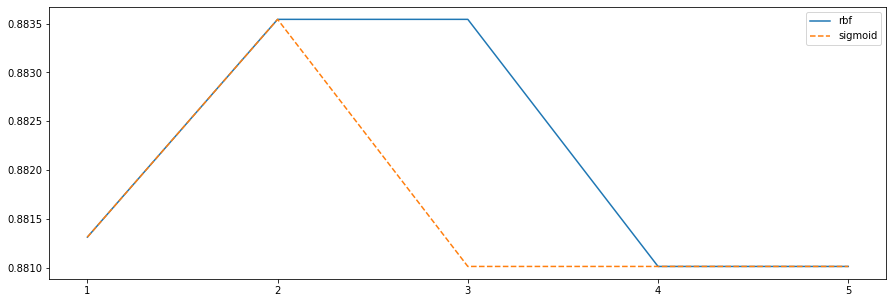

In [30]:
crossVal={}
for method in ['rbf','sigmoid']:
    temp=[];
    for train_index, test_index in skf.split(X_train, y_train):
        
        X_, X_val = X_train.iloc[train_index,:], X_train.iloc[test_index,:];
        y_, y_val = y_train[train_index], y_train[test_index];
        clf = make_pipeline(StandardScaler(), SVC(kernel=method, gamma='auto'))
        clf.fit(X_, y_)
        
        temp.append(clf.score(X_val, y_val))
    crossVal[method]=temp;


fig, ax = plt.subplots(1,1, figsize=(15,5));
plt.plot(np.arange(1,6), crossVal['rbf'], label='rbf')
plt.plot(np.arange(1,6), crossVal['sigmoid'], label='sigmoid', linestyle='dashed')
ax.set_xticks(np.arange(1,6, dtype='int'))
ax.legend()

In [31]:
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto'))
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8812749451908483

## ANN

In [32]:
import warnings

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.exceptions import ConvergenceWarning

In [33]:
validate={};
for i in [100, 500, 1000]:
    temp=[]
    for train_index, test_index in skf.split(X_train, y_train):
        
        X_, X_val = X_train.iloc[train_index,:], X_train.iloc[test_index,:];
        y_, y_val = y_train[train_index], y_train[test_index];

    
        X_scaled = StandardScaler().fit_transform(X_);
        X_val_scaled = StandardScaler().fit_transform(X_val);
    
        mlp = MLPClassifier(random_state=30, hidden_layer_sizes=i, learning_rate_init= 0.001, max_iter=10000, solver='adam');
        mlp.fit(X_scaled, y_)
        temp.append(mlp.score(X_val_scaled, y_val))

        
    validate['{}'.format(int(i))] = np.mean(np.array(temp), axis=0)
    

validate
    
   

{'100': 0.8623462472829562,
 '500': 0.856266462089247,
 '1000': 0.8572791203170951}

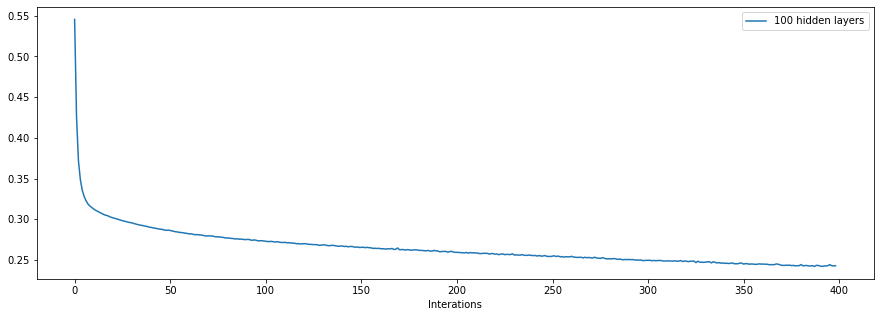

In [34]:
fig, ax= plt.subplots(1,1, figsize=(15,5));
mlp = MLPClassifier(random_state=30, hidden_layer_sizes=100, learning_rate_init= 0.001, max_iter=1000, solver='adam')
X_train_scaled = StandardScaler().fit_transform(X_train);
mlp.fit(X_train_scaled, y_train);
ax.plot(mlp.loss_curve_, label='{} hidden layers'.format(100));
ax.set_xlabel("Interations")
ax.legend()

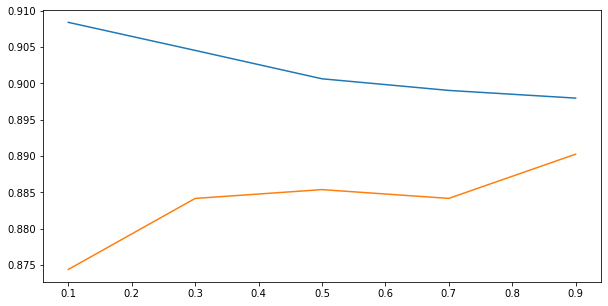

In [35]:
test_acc=[];
train_acc=[];
for k in np.linspace(0.1, 0.9, num=5, endpoint=True):
    X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=k, random_state=4000, stratify=y);
    mlp = MLPClassifier(random_state=30, hidden_layer_sizes=100, learning_rate_init= 0.001, max_iter=1000, solver='adam')
    X_train_scaled = StandardScaler().fit_transform(X_train);
    X_test_scaled = StandardScaler().fit_transform(X_test);
    mlp.fit(X_train_scaled, y_train)
    
    train_acc.append(mlp.score(X_train_scaled, y_train))
    test_acc.append(mlp.score(X_test_scaled, y_test));
    
fig, ax = plt.subplots(1,1, figsize=(10,5));
plt.plot(1-np.linspace(0.1, 0.9, num=5, endpoint=True), train_acc)
plt.plot(1-np.linspace(0.1, 0.9, num=5, endpoint=True), test_acc)

In [36]:
X_train_scaled = StandardScaler().fit_transform(X_train);
X_test_scaled = StandardScaler().fit_transform(X_test);
mlp.fit(X_train_scaled, y_train)
mlp.score(X_train_scaled, y_train)

0.9084008097165992